In [1]:
using Pkg
Pkg.status()
Pkg.instantiate()

Project ColonyImages v1.0.0-DEV
Status `C:\Users\ank10ki\Dropbox\phd\Image analysis\ColonyImages\Project.toml`
  [336ed68f] CSV v0.10.11
  [a93c6f00] DataFrames v1.6.1
⌃ [e30172f5] Documenter v1.1.2
  [7a1cc6ca] FFTW v1.7.1
  [5789e2e9] FileIO v1.16.1
  [916415d5] Images v0.26.0
  [2913bbd2] StatsBase v0.34.2
  [ade2ca70] Dates
  [9a3f8284] Random
  [10745b16] Statistics v1.9.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [23]:
using Revise, CairoMakie
using ColonyImages
using DataFrames, CSV, FileIO,LsqFit,Distributions, Serialization, DataFrames, DataFramesMeta, FFTW

In [3]:
using Images, FileIO, BenchmarkTools, CairoMakie, Distributions 
using FFTW, Revise, DataFrames, Chain, DataFramesMeta, StatsBase, Serialization, CSV, LsqFit, FindPeaks1D


In [3]:
image_data = "data/metrics"
for (i,x) in enumerate(readdir(image_data))
    println(i,"  ",x)
end

1  artifical_2023_09_14.csv
2  artifical_2023_09_14.jls
3  artifical_2023_long_evo.csv
4  artifical_2023_long_evo.jls
5  data_sets_10_2023-09-26.csv
6  data_sets_10_2023-09-26.jls


In [4]:
data = deserialize(joinpath(image_data,readdir(image_data)[6]))
first(data,3)

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,10_04_23_stacked_half_res,Kolonie 1.tif,0,"[0, 0, 9, 6, 10, 7, 10, 8, 9, 10 … 7, 10, 9, 8, 10, 7, 10, 6, 9, 31]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[5559, 4601, 5198, 5279, 5880, 5995, 5346, 5303, 5640, 5372 … 5580, 5552, 5217, 5350, 5937, 5874, 5349, 5206, 4648, 4117]","[5758, 4674, 5309, 5623, 5806, 5562, 5455, 5559, 5864, 5365 … 5462, 5770, 5571, 5404, 5380, 5718, 5610, 5264, 4708, 6501]",2992
2,10_04_23_stacked_half_res,Kolonie 1.tif,24,"[0, 0, 1, 1, 0, 1, 1, 0, 1, 0 … 0, 1, 1, 1, 3, 3, 4, 7, 14, 1]","[0, 0, 5, 4, 1, 5, 1, 4, 3, 4 … 3, 5, 4, 4, 1, 5, 1, 4, 5, 5]","[4967, 9556, 9432, 9550, 9202, 9044, 8702, 8631, 8167, 7888 … 5577, 5452, 5697, 5454, 5400, 5359, 5500, 5342, 5361, 2877]","[13720, 12768, 12385, 12375, 11863, 11534, 11136, 10556, 10170, 9835 … 5472, 5267, 5013, 5112, 4762, 4758, 4721, 4655, 4557, 6184]",2992
3,10_04_23_stacked_half_res,Kolonie 1.tif,48,"[0, 0, 1, 1, 0, 1, 1, 0, 1, 0 … 0, 1, 2, 1, 3, 3, 4, 7, 14, 2]","[0, 0, 5, 4, 1, 5, 1, 4, 3, 4 … 3, 5, 3, 4, 1, 5, 1, 4, 5, 5]","[9461, 18602, 18010, 17303, 16246, 15505, 14334, 13325, 11970, 10896 … 6515, 6364, 6471, 6492, 6469, 6350, 6336, 6267, 6294, 2965]","[20368, 19943, 19544, 18487, 17471, 15971, 14825, 13681, 12313, 10976 … 6549, 6579, 6606, 6381, 6384, 6182, 6154, 5955, 5950, 5844]",2992


In [5]:
unique(data.data_set)

10-element Vector{String}:
 "10_04_23_stacked_half_res"
 "14_06_23_stacked_full_res"
 "14_06_23_stacked_half_res"
 "17_05_23_stacked_full_res"
 "17_05_23_stacked_half_res"
 "19_12_22_stacked_full_res"
 "26_06_23_stacked_full_res"
 "27_04_22_stacked_half_res_expo"
 "27_04_22_stacked_full_res_expo"
 "28_03_23_stacked_half_res"

In [6]:
data_full = filter(row -> row.data_set[end-7:end] =="full_res", data )
unique(data_full.data_set)

4-element Vector{String}:
 "14_06_23_stacked_full_res"
 "17_05_23_stacked_full_res"
 "19_12_22_stacked_full_res"
 "26_06_23_stacked_full_res"

In [7]:
data_full[22,:]

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
22,14_06_23_stacked_full_res,Kolonie-6 seg.tif,24,"[0, 21, 4, 3, 6, 2, 3, 4, 8, 9 … 3, 9, 31, 37, 46, 52, 55, 63, 70, 121]","[0, 25, 19, 14, 14, 17, 20, 23, 26, 30 … 15, 27, 49, 56, 64, 69, 71, 74, 76, 104]","[4254, 8618, 8607, 8226, 7885, 7669, 7427, 7099, 6775, 6495 … 5403, 5396, 5313, 5199, 5107, 5148, 5147, 5163, 5175, 2628]","[12075, 12122, 11394, 10883, 10358, 9885, 9185, 8412, 7855, 7105 … 5512, 5241, 5137, 5106, 5042, 4846, 4798, 4770, 4855, 5114]",14333


In [8]:
path = "analysis\\Real_data"
mkpath(path)

"analysis\\Real_data"

In [9]:
data_pic = @subset(data_full , :data_set .== "26_06_23_stacked_full_res")
first(data_pic)

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,26_06_23_stacked_full_res,Kolonie-1 seg manuell.tif,0,"[0, 74, 75, 76, 76, 74, 77, 74, 76, 79 … 53, 58, 58, 64, 68, 76, 81, 78, 78, 169]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3190, 5696, 5733, 5873, 5626, 5733, 5734, 5943, 5842, 5667 … 5537, 5599, 5608, 5589, 5631, 5627, 5536, 5540, 5589, 2859]","[5550, 5894, 5887, 5806, 5851, 5695, 5828, 5727, 5649, 5788 … 5558, 5697, 5682, 5500, 5598, 5566, 5543, 5608, 5571, 5586]",22171


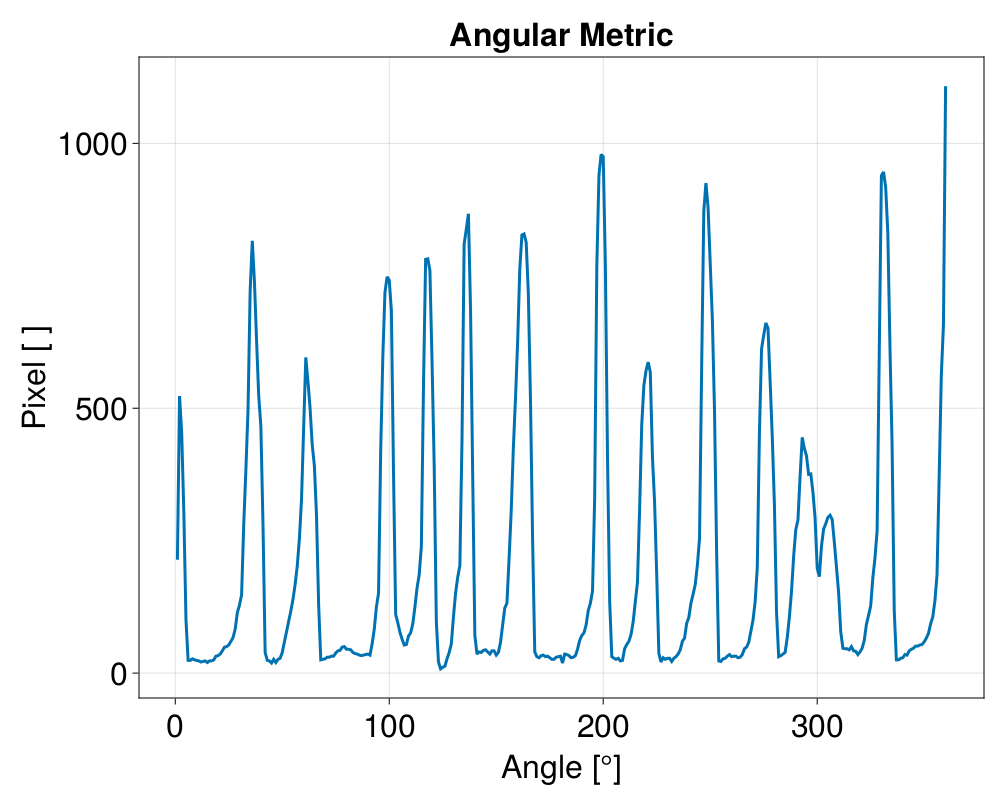

In [10]:
fig22 = Figure(fontsize = 32,resolution = (1000,800))
ax = CairoMakie.Axis(fig22[1,1], title = "Angular Metric",xlabel = "Angle [°]",  ylabel = "Pixel [ ]")
lines!(ax,data_pic.metric_OG[12], linewidth = 3)



fig22

In [11]:
save("plots/angular.png", fig22)

CairoMakie.Screen{IMAGE}


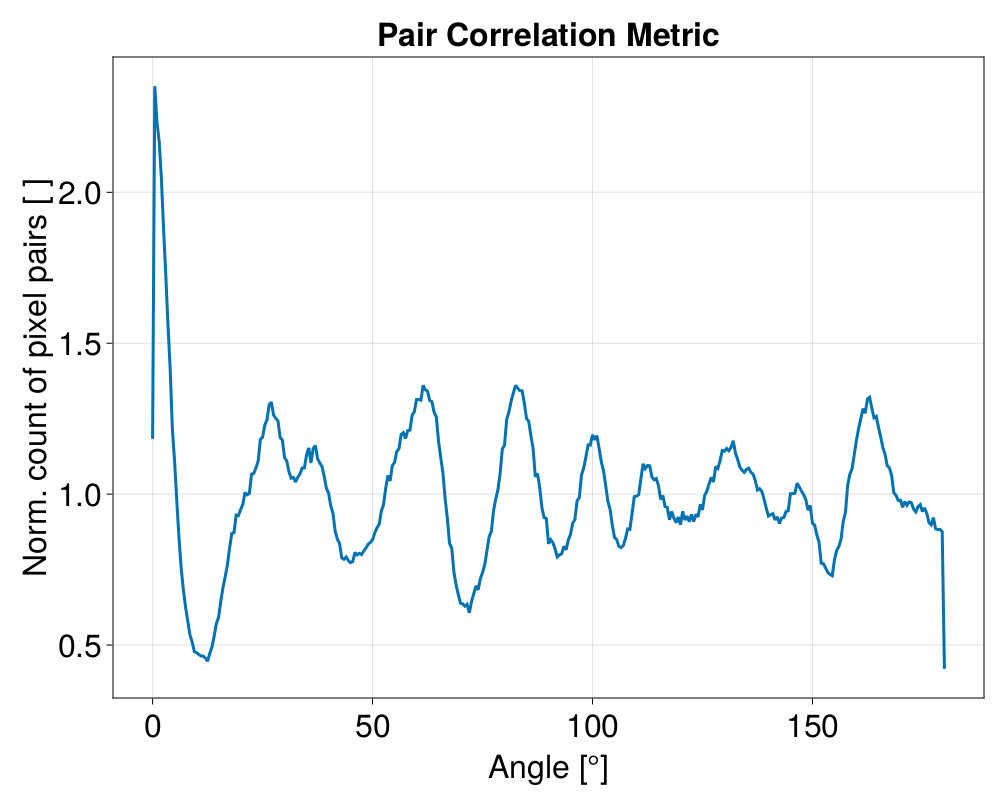

In [24]:
fig23 = Figure(fontsize = 32,resolution = (1000,800))
ax = CairoMakie.Axis(fig23[1,1], title = "Pair Correlation Metric",xlabel = "Angle [°]",  ylabel = "Norm. count of pixel pairs [ ]")
lines!(ax,0:0.5:180,data_pic.pair_OG[12]./mean(data_pic.pair_OG[12]), linewidth = 3)


fig23

In [25]:
save("plots/pair.png", fig23)

CairoMakie.Screen{IMAGE}


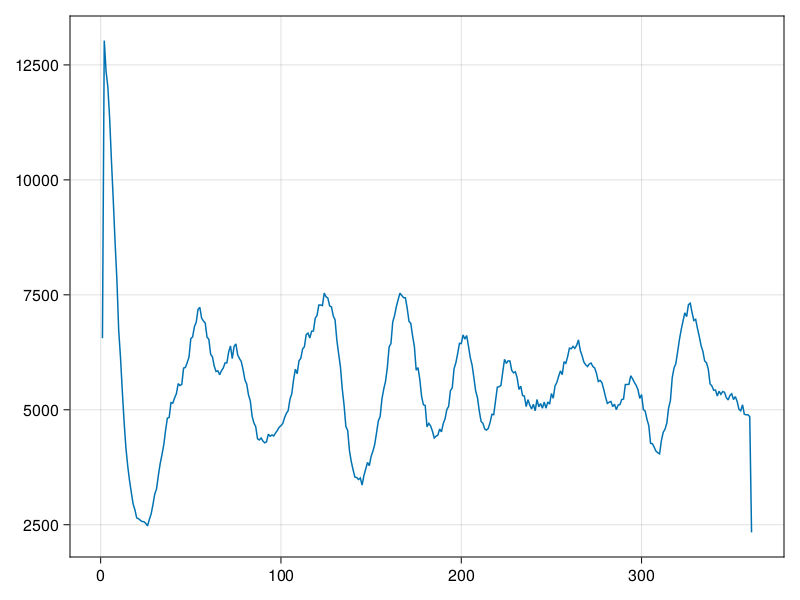

In [27]:
lines(data_pic.pair_OG[12])

In [28]:
pair_max = @chain data_full begin
    #@subset(:data_set .== "14_06_23_stacked_full_res")
    groupby(:time)
     @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
        :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
    
end

Row,time,pair_og,pair_og_stdd
,Int64,Float64,Float64
1,0,0.0590085,0.0193867
2,3,0.534521,0.406161
3,4,0.603532,0.221662
4,19,0.458936,0.274609
5,20,0.318402,0.1617
6,24,0.684652,0.22927
7,43,1.12358,0.163496
8,44,1.01706,0.190581
9,48,1.25448,0.281709


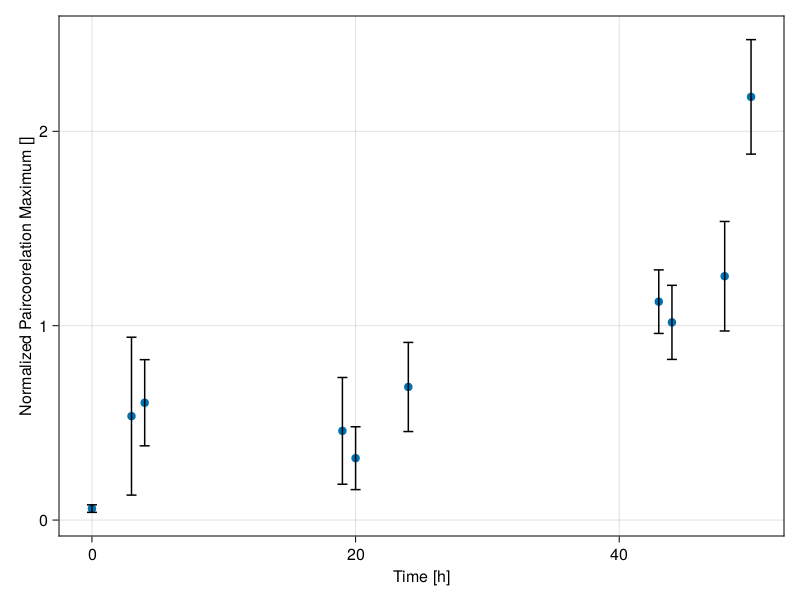

In [29]:
fig1 = scatter(pair_max.time,pair_max.pair_og)
errorbars!(pair_max.time,pair_max.pair_og, pair_max.pair_og_stdd,whiskerwidth = 10)
fig1.axis.xlabel ="Time [h]"
fig1.axis.ylabel ="Normalized Paircoorelation Maximum []"
save(joinpath(path,"Normalized_Paircoorelation_Maximum.png"),fig1)
fig1

In [30]:
pair_max_single = @chain data_full begin
    groupby([:time,:data_set])
    @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
    :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
    
    
end

Row,time,data_set,pair_og,pair_og_stdd
,Int64,String,Float64,Float64
1,0,14_06_23_stacked_full_res,0.0657923,0.0113825
2,4,14_06_23_stacked_full_res,0.603532,0.221662
3,20,14_06_23_stacked_full_res,0.318402,0.1617
4,24,14_06_23_stacked_full_res,0.531813,0.221004
5,44,14_06_23_stacked_full_res,1.01706,0.190581
6,48,14_06_23_stacked_full_res,1.06041,0.196028
7,0,17_05_23_stacked_full_res,0.0626551,0.0272275
8,24,17_05_23_stacked_full_res,0.714557,0.241602
9,48,17_05_23_stacked_full_res,1.38889,0.306708


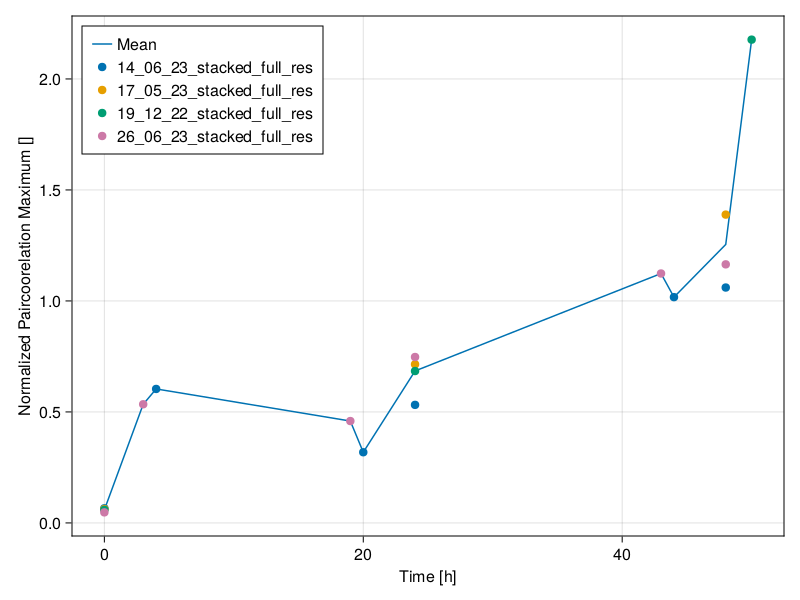

In [31]:
fig1 = lines(pair_max.time,pair_max.pair_og, label ="Mean" )
#errorbars!(pair_max.time,pair_max.pair_og, pair_max.pair_og_stdd,whiskerwidth = 10)

for (k, i) in pairs(groupby(pair_max_single,:data_set))
    scatter!(fig1.axis, i.time, i.pair_og, label = String(k.data_set))
end
fig1.axis.xlabel ="Time [h]"
fig1.axis.ylabel ="Normalized Paircoorelation Maximum []"
axislegend(fig1.axis, position = :lt)
save(joinpath(path,"Normalized_Paircoorelation_Maximum_inidvidual.png"),fig1)
fig1

In [32]:
first(data_full,3)

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,14_06_23_stacked_full_res,Kolonie-1 seg.tif,0,"[0, 36, 51, 46, 47, 47, 48, 48, 46, 51 … 44, 51, 46, 47, 48, 47, 47, 46, 49, 109]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3117, 5369, 5589, 5610, 5596, 5626, 5537, 5642, 5434, 5611 … 5505, 5562, 5652, 5513, 5652, 5562, 5505, 5716, 5383, 2871]","[5338, 5545, 5520, 5777, 5550, 5610, 5518, 5535, 5527, 5602 … 5616, 5696, 5670, 5574, 5547, 5678, 5615, 5610, 5518, 5621]",16675
2,14_06_23_stacked_full_res,Kolonie-1 seg.tif,4,"[0, 2, 2, 3, 1, 0, 0, 0, 0, 4 … 4, 4, 3, 1, 2, 2, 1, 3, 2, 5]","[0, 8, 13, 7, 5, 5, 6, 5, 3, 4 … 12, 12, 11, 9, 10, 9, 7, 9, 12, 15]","[3632, 6620, 6974, 6849, 6695, 6984, 6875, 6834, 6731, 6705 … 4923, 4960, 5105, 5008, 5103, 5086, 5061, 5176, 4982, 2480]","[53197, 8080, 2853, 9266, 6767, 3679, 7140, 2081, 6424, 5500 … 5285, 6094, 2093, 6830, 3258, 6484, 8406, 2451, 6957, 55016]",16675
3,14_06_23_stacked_full_res,Kolonie-1 seg.tif,20,"[0, 16, 20, 24, 33, 28, 16, 7, 5, 3 … 1, 2, 2, 1, 1, 0, 0, 1, 2, 104]","[0, 46, 38, 50, 57, 53, 40, 30, 30, 27 … 26, 26, 27, 25, 25, 25, 24, 27, 22, 61]","[3022, 6227, 6049, 6095, 6048, 5950, 5933, 5846, 5788, 5822 … 5474, 5452, 5407, 5292, 5479, 5473, 5564, 5450, 5505, 2687]","[12716, 10017, 9683, 9298, 8816, 8163, 7364, 6751, 6487, 5798 … 6011, 6138, 5883, 5803, 6170, 6057, 6088, 6008, 5970, 8752]",16675


In [33]:
cv_angular_max = @chain data_full begin
    groupby(:time)
    @combine(:cv_OG = mean(std.(:metric_OG)./(mean.(:metric_OG))))
    
    
end

Row,time,cv_OG
,Int64,Float64
1,0,NaN
2,3,0.695513
3,4,0.720371
4,19,0.639922
5,20,0.548096
6,24,0.818629
7,43,1.06527
8,44,1.01741
9,48,1.12087


In [34]:
cv_angular_max_single = @chain data_full begin 
    groupby([:time,:data_set])
    @combine(:cv_angu = mean(std.(:metric_OG)./(mean.(:metric_OG))))
end

Row,time,data_set,cv_angu
,Int64,String,Float64
1,0,14_06_23_stacked_full_res,NaN
2,4,14_06_23_stacked_full_res,0.720371
3,20,14_06_23_stacked_full_res,0.548096
4,24,14_06_23_stacked_full_res,0.717688
5,44,14_06_23_stacked_full_res,1.01741
6,48,14_06_23_stacked_full_res,1.03337
7,0,17_05_23_stacked_full_res,NaN
8,24,17_05_23_stacked_full_res,0.834319
9,48,17_05_23_stacked_full_res,1.17691


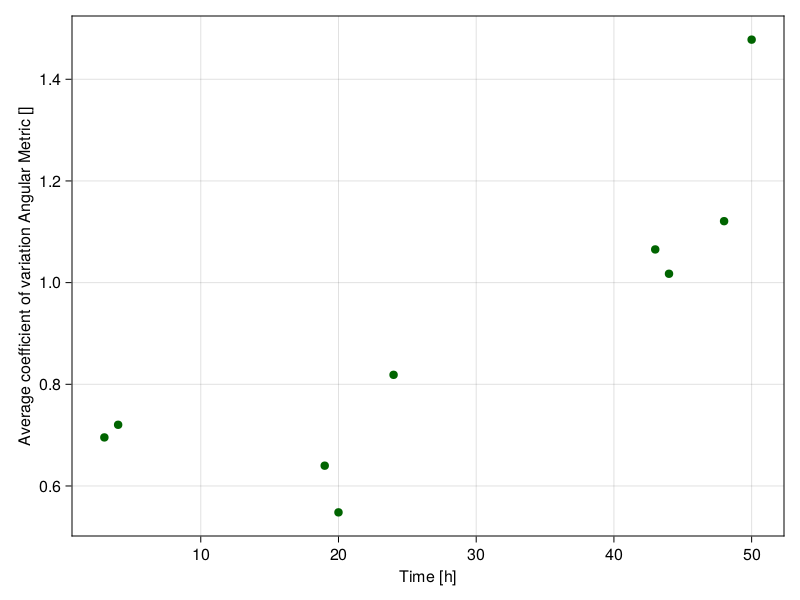

In [35]:
fig2 = scatter(cv_angular_max.time,cv_angular_max.cv_OG, color = "darkgreen", whiskerwidth = 10)
#errorbars!(cv_angu.time,cv_angular_max.cv_angu, ,whiskerwidth = 10)
fig2.axis.xlabel ="Time [h]"
fig2.axis.ylabel ="Average coefficient of variation Angular Metric []"
save(joinpath(path,"Average coefficient of variation Angular Metric.png"),fig2)
fig2

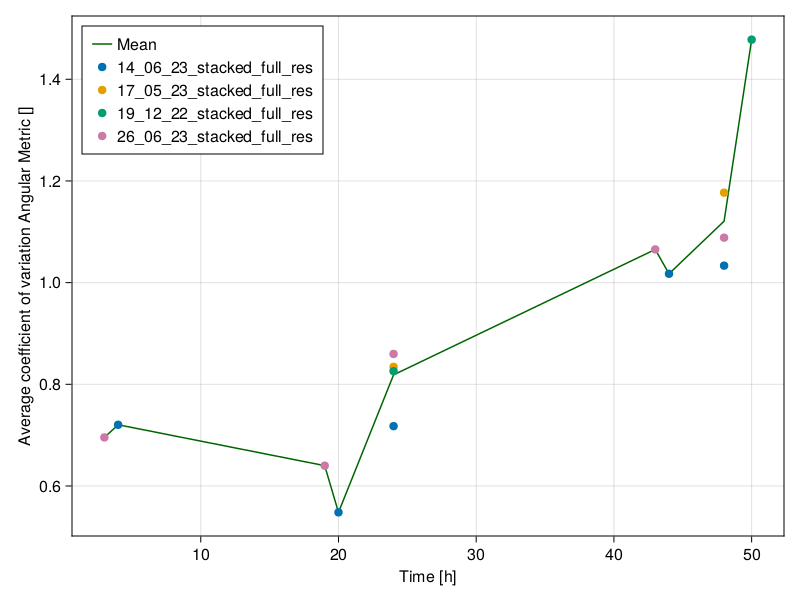

In [36]:
fig2 = lines(cv_angular_max.time,cv_angular_max.cv_OG, color = "darkgreen", whiskerwidth = 10, label = "Mean")
#scatter!(fig4.axis,abs_fftw.time,abs_fftw.abs_cov_n, color = "red", whiskerwidth = 10)
#errorbars!(cv_angu.time,cv_angular_max.cv_angu, ,whiskerwidth = 10)
for (k, i) in pairs(groupby(cv_angular_max_single,:data_set))
    scatter!(fig2.axis, i.time, i.cv_angu, label = String(k.data_set))
end
axislegend(fig2.axis, position = :lt)
fig2.axis.xlabel ="Time [h]"
fig2.axis.ylabel ="Average coefficient of variation Angular Metric []"
save(joinpath(path,"Average coefficient of variation Angular Metric.png"),fig2)
fig2

In [37]:
fft_data = @chain data_full begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[2:360÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[2:360÷2]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end
first(fft_data)

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size,fourier_conv,fourier_OG,abs_cov,abs_OG,abs_cov_n,abs_OG_n
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Array…,Array…,Array…,Array…,Array…,Array…
1,14_06_23_stacked_full_res,Kolonie-1 seg.tif,0,"[0, 36, 51, 46, 47, 47, 48, 48, 46, 51 … 44, 51, 46, 47, 48, 47, 47, 46, 49, 109]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3117, 5369, 5589, 5610, 5596, 5626, 5537, 5642, 5434, 5611 … 5505, 5562, 5652, 5513, 5652, 5562, 5505, 5716, 5383, 2871]","[5338, 5545, 5520, 5777, 5550, 5610, 5518, 5535, 5527, 5602 … 5616, 5696, 5670, 5574, 5547, 5678, 5615, 5610, 5518, 5621]",16675,"ComplexF64[16675.0+0.0im, 99.5793-13.2053im, 43.3882+49.9286im, 135.108-24.3583im, 1.62511-53.0144im, -44.7534-30.9749im, -55.9687+52.126im, 72.7058+15.0427im, -17.9243-0.0067771im, 17.2809+22.9634im … -5.30812-45.8975im, 17.2809-22.9634im, -17.9243+0.0067771im, 72.7058-15.0427im, -55.9687-52.126im, -44.7534+30.9749im, 1.62511+53.0144im, 135.108+24.3583im, 43.3882-49.9286im, 99.5793+13.2053im]","ComplexF64[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im … 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im]","[100.451, 66.1468, 137.287, 53.0393, 54.4271, 76.4828, 74.2457, 17.9243, 28.7393, 46.2034 … 140.776, 129.545, 74.5963, 145.949, 152.095, 135.649, 137.425, 149.264, 152.104, 142.672]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.00602405, 0.00396682, 0.00823308, 0.00318077, 0.003264, 0.00458667, 0.00445252, 0.00107492, 0.0017235, 0.00277082 … 0.00844231, 0.0077688, 0.00447354, 0.00875258, 0.00912113, 0.00813486, 0.0082414, 0.00895137, 0.00912167, 0.00855601]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [40]:
abs_fftw = @chain fft_data begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)) )
end

Row,time,abs_og,abs_cov,abs_og_n,abs_cov_n
,Int64,Float64,Float64,Float64,Float64
1,0,0.0,21127.7,0.0,1.0815
2,3,6178.51,18460.8,0.232763,0.630841
3,4,5204.01,12806.5,0.342147,0.856198
4,19,59156.7,61133.3,2.14392,2.19139
5,20,44972.9,44927.8,2.95133,2.93397
6,24,84390.7,83534.8,4.18188,4.13021
7,43,3.18116e5,3.16579e5,11.3236,11.2641
8,44,2.61143e5,2.59082e5,17.0809,16.9521
9,48,3.32596e5,3.30848e5,16.1378,16.0472


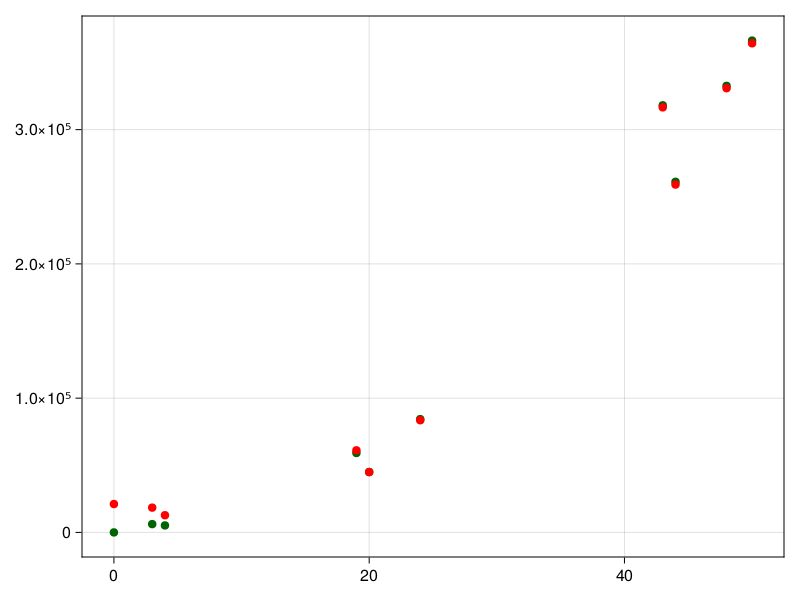

In [41]:
fig3 = scatter(abs_fftw.time,abs_fftw.abs_og, color = "darkgreen", whiskerwidth = 10)
scatter!(fig3.axis,abs_fftw.time,abs_fftw.abs_cov, color = "red", whiskerwidth = 10)
#errorbars!(cv_angu.time,cv_angular_max.cv_angu, ,whiskerwidth = 10)
fig3

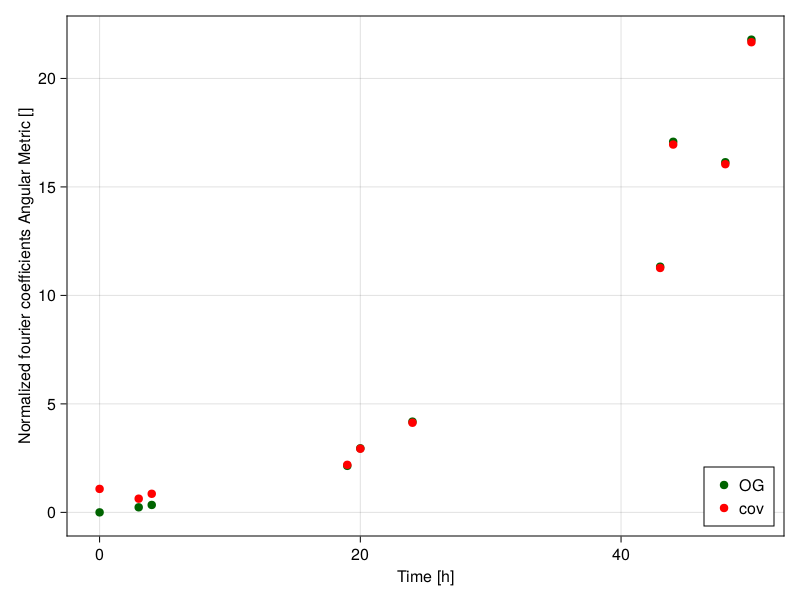

In [42]:
fig4 = scatter(abs_fftw.time,abs_fftw.abs_og_n, color = "darkgreen", whiskerwidth = 10, label = "OG")
scatter!(fig4.axis,abs_fftw.time,abs_fftw.abs_cov_n, color = "red", whiskerwidth = 10, label =  "cov")
#errorbars!(cv_angu.time,cv_angular_max.cv_angu, ,whiskerwidth = 10)
fig4.axis.xlabel ="Time [h]"
fig4.axis.ylabel ="Normalized fourier coefficients Angular Metric []"

axislegend(fig4.axis, position = :rb)
save(joinpath(path,"Average Normalized fourier coefficients Angular Metric Angular Metric.png"),fig4)
fig4


### Compare different datasets: 



In [43]:
first(data,3)

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,10_04_23_stacked_half_res,Kolonie 1.tif,0,"[0, 0, 9, 6, 10, 7, 10, 8, 9, 10 … 7, 10, 9, 8, 10, 7, 10, 6, 9, 31]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[5559, 4601, 5198, 5279, 5880, 5995, 5346, 5303, 5640, 5372 … 5580, 5552, 5217, 5350, 5937, 5874, 5349, 5206, 4648, 4117]","[5758, 4674, 5309, 5623, 5806, 5562, 5455, 5559, 5864, 5365 … 5462, 5770, 5571, 5404, 5380, 5718, 5610, 5264, 4708, 6501]",2992
2,10_04_23_stacked_half_res,Kolonie 1.tif,24,"[0, 0, 1, 1, 0, 1, 1, 0, 1, 0 … 0, 1, 1, 1, 3, 3, 4, 7, 14, 1]","[0, 0, 5, 4, 1, 5, 1, 4, 3, 4 … 3, 5, 4, 4, 1, 5, 1, 4, 5, 5]","[4967, 9556, 9432, 9550, 9202, 9044, 8702, 8631, 8167, 7888 … 5577, 5452, 5697, 5454, 5400, 5359, 5500, 5342, 5361, 2877]","[13720, 12768, 12385, 12375, 11863, 11534, 11136, 10556, 10170, 9835 … 5472, 5267, 5013, 5112, 4762, 4758, 4721, 4655, 4557, 6184]",2992
3,10_04_23_stacked_half_res,Kolonie 1.tif,48,"[0, 0, 1, 1, 0, 1, 1, 0, 1, 0 … 0, 1, 2, 1, 3, 3, 4, 7, 14, 2]","[0, 0, 5, 4, 1, 5, 1, 4, 3, 4 … 3, 5, 3, 4, 1, 5, 1, 4, 5, 5]","[9461, 18602, 18010, 17303, 16246, 15505, 14334, 13325, 11970, 10896 … 6515, 6364, 6471, 6492, 6469, 6350, 6336, 6267, 6294, 2965]","[20368, 19943, 19544, 18487, 17471, 15971, 14825, 13681, 12313, 10976 … 6549, 6579, 6606, 6381, 6384, 6182, 6154, 5955, 5950, 5844]",2992


In [44]:
abs_fftw_single = @chain fft_data begin 
    groupby([:time,:data_set])
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)) )
end

Row,time,data_set,abs_og,abs_cov,abs_og_n,abs_cov_n
,Int64,String,Float64,Float64,Float64,Float64
1,0,14_06_23_stacked_full_res,0.0,17692.3,0.0,1.17195
2,4,14_06_23_stacked_full_res,5204.01,12806.5,0.342147,0.856198
3,20,14_06_23_stacked_full_res,44972.9,44927.8,2.95133,2.93397
4,24,14_06_23_stacked_full_res,72985.5,70933.9,4.79058,4.65836
5,44,14_06_23_stacked_full_res,2.61143e5,2.59082e5,17.0809,16.9521
6,48,14_06_23_stacked_full_res,302456.0,3.00666e5,19.7556,19.6392
7,0,17_05_23_stacked_full_res,0.0,22045.2,0.0,1.15892
8,24,17_05_23_stacked_full_res,86166.3,85250.5,4.38438,4.32719
9,48,17_05_23_stacked_full_res,3.12516e5,3.09523e5,15.8924,15.758


In [45]:
a =0
for (k,i) in pairs(groupby(abs_fftw_single,:data_set))
    println(k)
    a = k
end


GroupKey: (data_set = "14_06_23_stacked_full_res",)
GroupKey: (data_set = "17_05_23_stacked_full_res",)
GroupKey: (data_set = "19_12_22_stacked_full_res",)
GroupKey: (data_set = "26_06_23_stacked_full_res",)


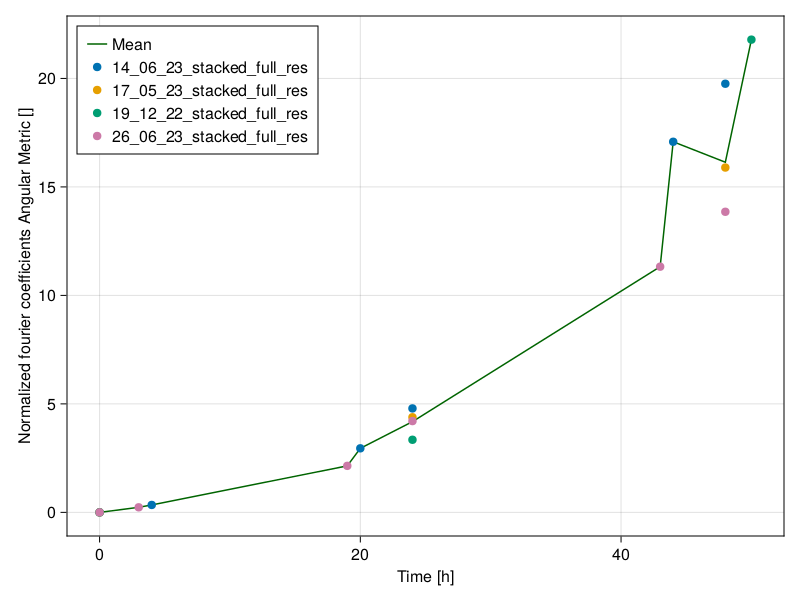

In [46]:
fig4 = lines(abs_fftw.time,abs_fftw.abs_og_n, color = "darkgreen", whiskerwidth = 10, label = "Mean")
#scatter!(fig4.axis,abs_fftw.time,abs_fftw.abs_cov_n, color = "red", whiskerwidth = 10)
#errorbars!(cv_angu.time,cv_angular_max.cv_angu, ,whiskerwidth = 10)
for (k, i) in pairs(groupby(abs_fftw_single,:data_set))
    scatter!(fig4.axis, i.time, i.abs_og_n, label = String(k.data_set))
end
fig4.axis.xlabel ="Time [h]"
fig4.axis.ylabel ="Normalized fourier coefficients Angular Metric []"

axislegend(fig4.axis, position = :lt)

save(joinpath(path," Normalized fourier coefficients Angular Metric Angular Metric_cov.png"),fig4)
fig4

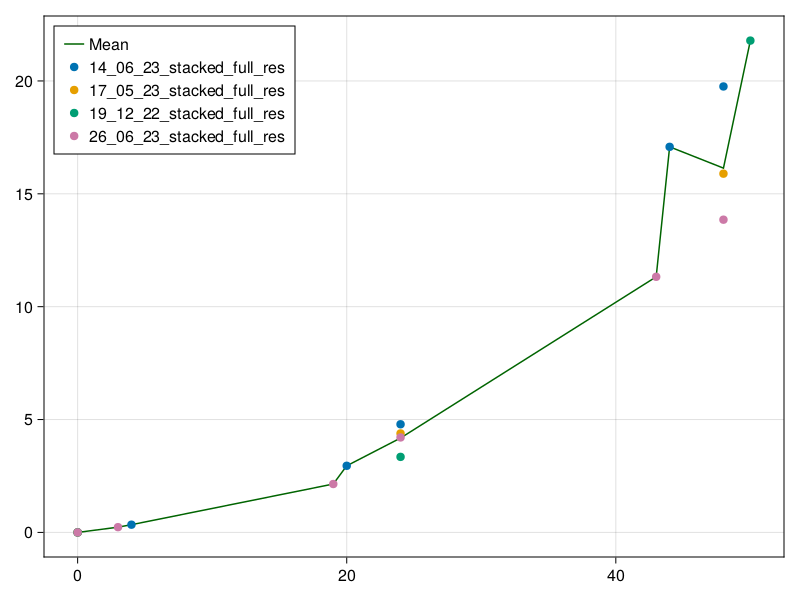

In [47]:
fig4 = lines(abs_fftw.time,abs_fftw.abs_og_n, color = "darkgreen", whiskerwidth = 10, label = "Mean")

for (k, i) in pairs(groupby(abs_fftw_single,:data_set))
    scatter!(fig4.axis, i.time, i.abs_og_n, label = String(k.data_set))
end
axislegend(fig4.axis, position = :lt)
fig4


In [48]:
first(fft_data)

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size,fourier_conv,fourier_OG,abs_cov,abs_OG,abs_cov_n,abs_OG_n
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Array…,Array…,Array…,Array…,Array…,Array…
1,14_06_23_stacked_full_res,Kolonie-1 seg.tif,0,"[0, 36, 51, 46, 47, 47, 48, 48, 46, 51 … 44, 51, 46, 47, 48, 47, 47, 46, 49, 109]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3117, 5369, 5589, 5610, 5596, 5626, 5537, 5642, 5434, 5611 … 5505, 5562, 5652, 5513, 5652, 5562, 5505, 5716, 5383, 2871]","[5338, 5545, 5520, 5777, 5550, 5610, 5518, 5535, 5527, 5602 … 5616, 5696, 5670, 5574, 5547, 5678, 5615, 5610, 5518, 5621]",16675,"ComplexF64[16675.0+0.0im, 99.5793-13.2053im, 43.3882+49.9286im, 135.108-24.3583im, 1.62511-53.0144im, -44.7534-30.9749im, -55.9687+52.126im, 72.7058+15.0427im, -17.9243-0.0067771im, 17.2809+22.9634im … -5.30812-45.8975im, 17.2809-22.9634im, -17.9243+0.0067771im, 72.7058-15.0427im, -55.9687-52.126im, -44.7534+30.9749im, 1.62511+53.0144im, 135.108+24.3583im, 43.3882-49.9286im, 99.5793+13.2053im]","ComplexF64[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im … 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im]","[100.451, 66.1468, 137.287, 53.0393, 54.4271, 76.4828, 74.2457, 17.9243, 28.7393, 46.2034 … 140.776, 129.545, 74.5963, 145.949, 152.095, 135.649, 137.425, 149.264, 152.104, 142.672]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.00602405, 0.00396682, 0.00823308, 0.00318077, 0.003264, 0.00458667, 0.00445252, 0.00107492, 0.0017235, 0.00277082 … 0.00844231, 0.0077688, 0.00447354, 0.00875258, 0.00912113, 0.00813486, 0.0082414, 0.00895137, 0.00912167, 0.00855601]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [49]:
test_spec = fft_data.abs_OG_n[6];

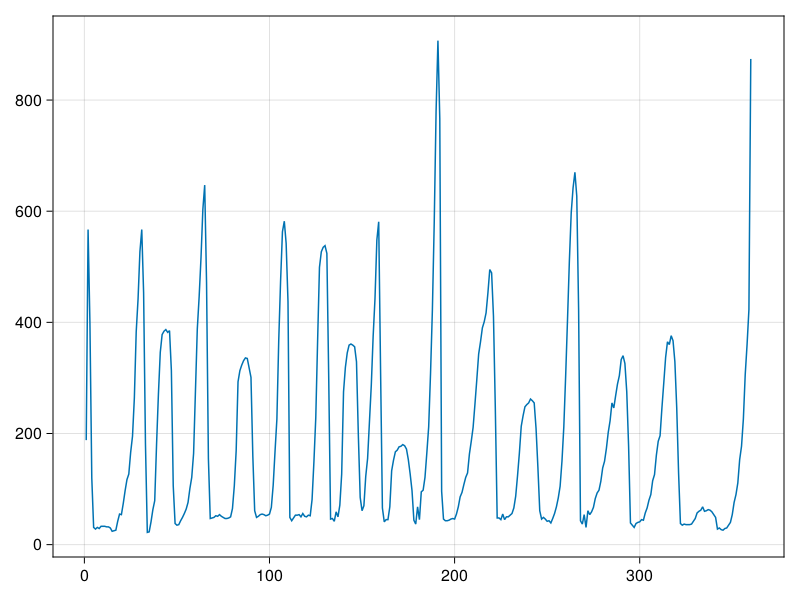

In [50]:
lines(fft_data.metric_OG[6])

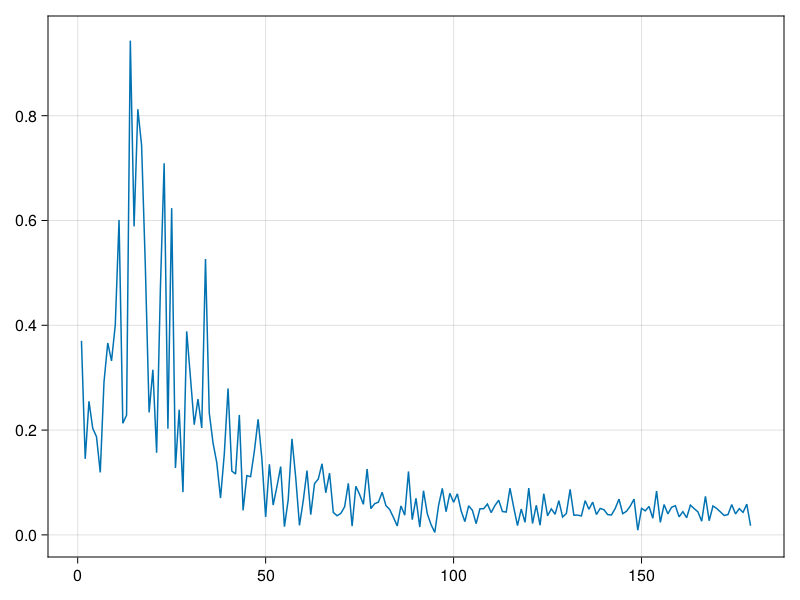

In [51]:
lines(test_spec)

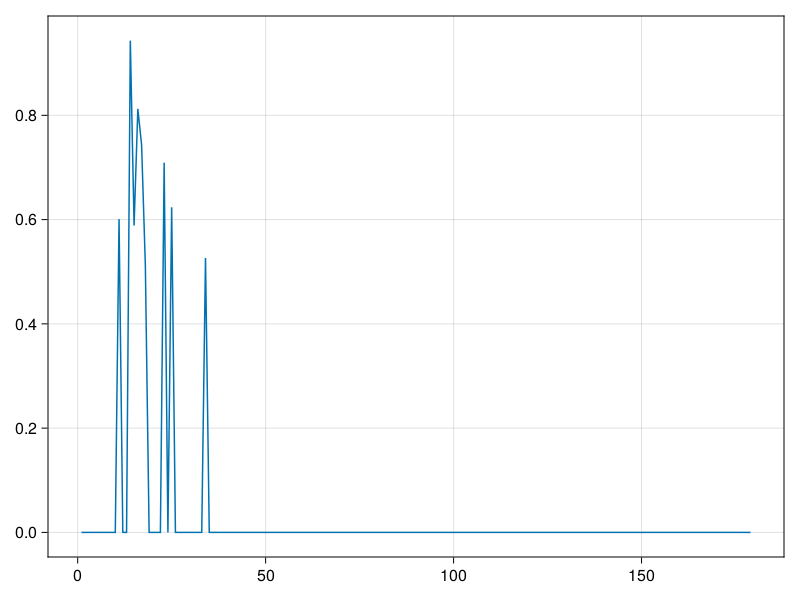

In [60]:
test_spec_fil_b = filter_fourier_beta(test_spec);
lines(test_spec_fil_b)

In [64]:
all_frequ = vcat(filter_fourier_beta.(fft_data.abs_OG_n)...)

26850-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [65]:
histo_data = vcat(find_freq.(filter_fourier_beta.(fft_data.abs_cov_n, b  =0.5))...);
fitt = fit(LogNormal,histo_data)


LogNormal{Float64}(μ=2.6983436448498748, σ=0.7155028531401669)

In [66]:
pdf3 = pdf.(fitt, collect(1:60));

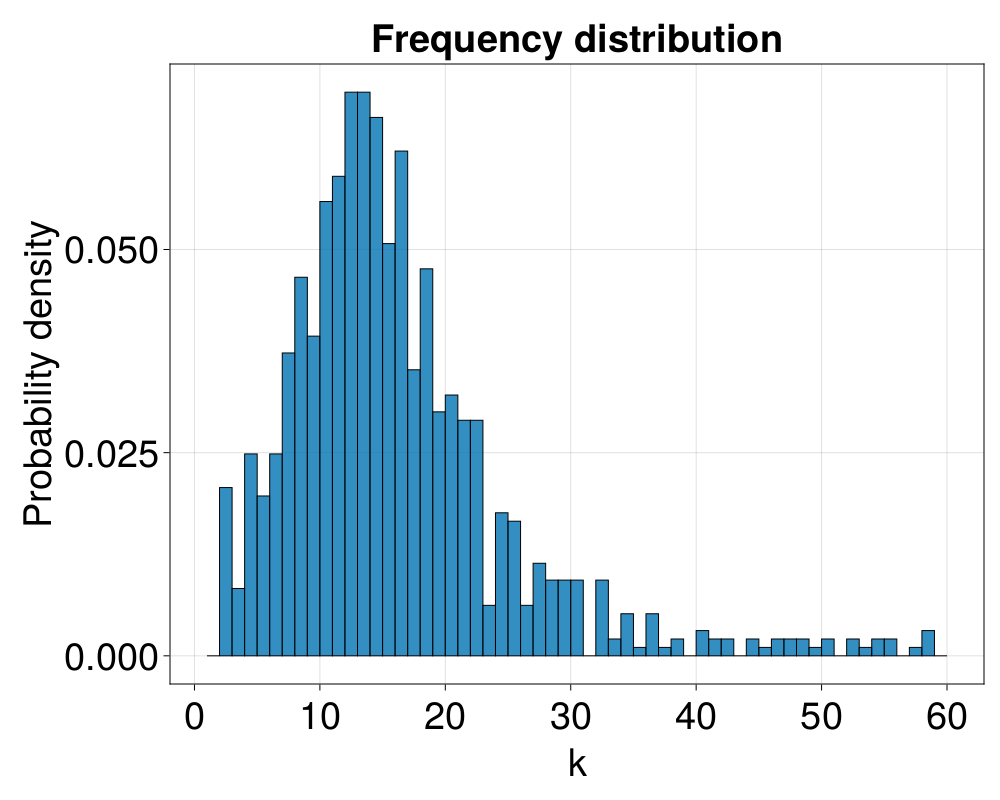

In [67]:
fig6 = Figure(fontsize = 38,resolution = (1000,800))
ax = CairoMakie.Axis(fig6[1,1], title = "Frequency distribution", xlabel = "k" , ylabel = "Probability density")
hist!(ax,histo_data, bins = 1:60,strokewidth = 1, normalization = :pdf)
#lines!(hans.axis, pdf3, linewidth = 10)
#hans.axis.title =  "Frequency distribution"
save(joinpath(path,"Frequency distribution.png"),fig6)
fig6

In [68]:
mean(histo_data)

19.478682170542637

In [69]:
median(histo_data)

14.0

In [70]:
std(histo_data)

17.366297645063746

In [71]:
histi_rev = (histo_data.^-1)*360

1032-element Vector{Float64}:
   4.5
 180.0
 120.0
  90.0
  60.0
  36.0
  25.71428571428571
  24.0
  22.5
  20.0
  18.0
  13.333333333333332
  12.857142857142856
   ⋮
  12.0
  10.90909090909091
  45.0
  36.0
  25.71428571428571
  22.5
  36.0
  25.71428571428571
  18.0
  36.0
  25.71428571428571
  18.0

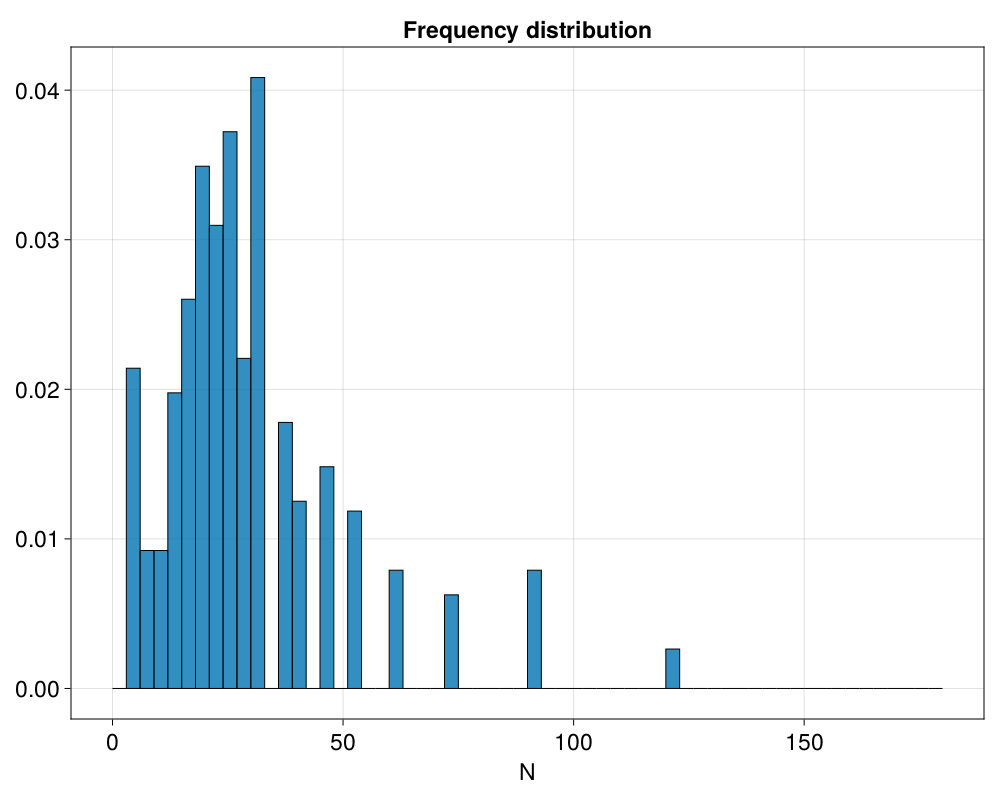

In [72]:
fig6 = Figure(fontsize = 23,resolution = (1000,800))
ax = CairoMakie.Axis(fig6[1,1], title = "Frequency distribution", xlabel = "N" )
hist!(ax,histi_rev,strokewidth = 1,bins =0:3:180 , normalization = :pdf)
#lines!(hans.axis, pdf3, linewidth = 10)
#hans.axis.title =  "Frequency distribution"
save(joinpath(path,"Frequency distribution.png"),fig6)
fig6

In [73]:
360/16

22.5

### Size increase measure in pixel in circular metric

In [74]:
first(data)

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,10_04_23_stacked_half_res,Kolonie 1.tif,0,"[0, 0, 9, 6, 10, 7, 10, 8, 9, 10 … 7, 10, 9, 8, 10, 7, 10, 6, 9, 31]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[5559, 4601, 5198, 5279, 5880, 5995, 5346, 5303, 5640, 5372 … 5580, 5552, 5217, 5350, 5937, 5874, 5349, 5206, 4648, 4117]","[5758, 4674, 5309, 5623, 5806, 5562, 5455, 5559, 5864, 5365 … 5462, 5770, 5571, 5404, 5380, 5718, 5610, 5264, 4708, 6501]",2992


In [75]:
size = @chain data_full begin 
    groupby([:time])
    @combine(:abs_size = mean(sum.(:metric_OG)) ,:abs_size_normalized = mean(sum.(:metric_OG))./mean(:OG_size) ,:OG_size = mean(:OG_size),
        :abs_size_normalized_std = std(sum.(:metric_OG))./mean(:OG_size) )
end

Row,time,abs_size,abs_size_normalized,OG_size,abs_size_normalized_std
,Int64,Float64,Float64,Float64,Float64
1,0,0.0,0.0,20440.8,0.0
2,3,2038.12,0.0709061,28744.0,0.0401588
3,4,1678.83,0.110482,15195.5,0.0742734
4,19,17691.8,0.615494,28744.0,0.223714
5,20,14938.2,0.983065,15195.5,0.131161
6,24,20884.1,1.02169,20440.8,0.381145
7,43,61265.8,2.13143,28744.0,0.337027
8,44,53696.8,3.53373,15195.5,0.627677
9,48,60257.4,2.80926,21449.6,0.842461


In [76]:
cor_size = size.abs_size_normalized.+1;

In [77]:
ex(x,p) =(1+(p[1])).^x
p1 = [0.001]
fit2 = curve_fit(ex,size.time ,cor_size , p1)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([0.02971700864000873], [0.0, 0.020920468692736005, 0.013790120504433956, 0.1288812812613076, -0.18685260688421934, -0.002255160001937373, 0.3912194838389902, -0.9064031334401292, 0.2688507607845403, 0.16279587837413967], [0.0; 3.180951353632231; … ; 190.0999062742328; 209.96477599076434;;], true, Iter     Function value   Gradient norm 
------   --------------   --------------
, Float64[])

In [78]:
y2 = ex(size.time,fit2.param)
fit2.param

1-element Vector{Float64}:
 0.02971700864000873

In [79]:
standard_errors(fit2)

1-element Vector{Float64}:
 0.000979379686497925

In [80]:
1/fit2.param[1]

33.65076250150144

In [98]:
fit2.resid

10-element Vector{Float64}:
  0.0
  0.020920468692736005
  0.013790120504433956
  0.1288812812613076
 -0.18685260688421934
 -0.002255160001937373
  0.3912194838389902
 -0.9064031334401292
  0.2688507607845403
  0.16279587837413967

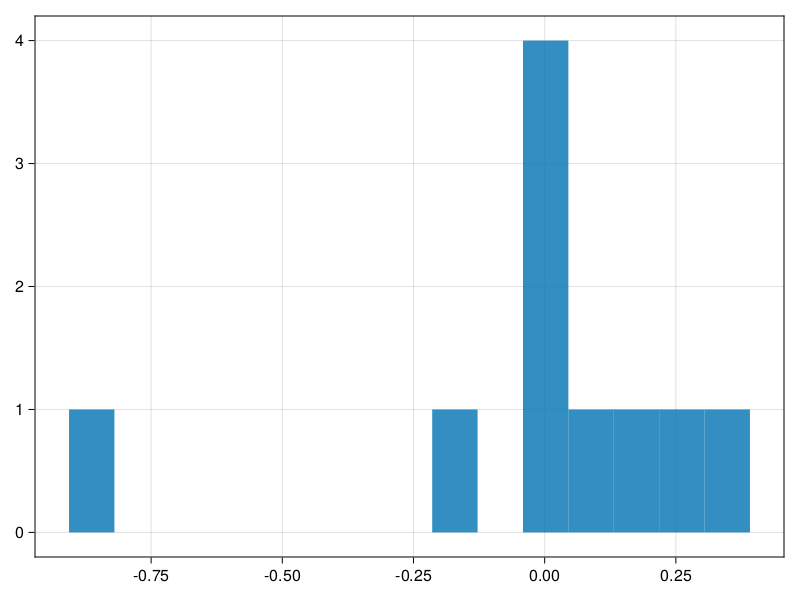

In [101]:
hist(fit2.resid)

In [100]:
sse  = sum(fit2.resid.^2)/10

0.11255597549748342

In [92]:
fit2.jacobian

10×1 Matrix{Float64}:
   0.0
   3.180951353632231
   4.367306283424039
  32.18663362895876
  34.887499058433214
  47.0676624014354
 147.10237614206525
 154.996465746938
 190.0999062742328
 209.96477599076434

In [83]:
ov = estimate_covar(fit2)

1×1 Matrix{Float64}:
 9.591845703247738e-7

In [95]:
margin_error(fit2)

1-element Vector{Float64}:
 0.0022155107729103407

In [97]:
confidence_interval(fit2, 0.1)

1-element Vector{Tuple{Float64, Float64}}:
 (0.027921695070708574, 0.031512322209308885)

In [84]:
using Statistics

In [91]:
se = standard_errors(fit2)

1-element Vector{Float64}:
 0.000979379686497925

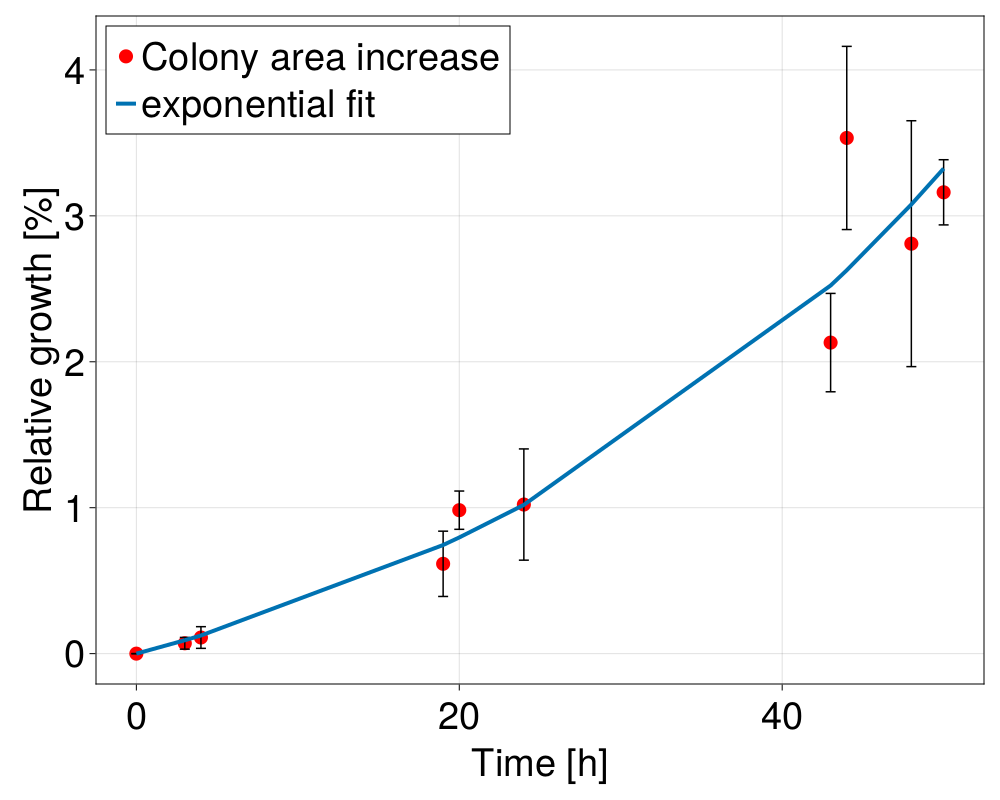

In [89]:
fig10 = Figure(fontsize = 38,resolution = (1000,800))
ax = CairoMakie.Axis(fig10[1,1])
scatter!(ax, size.time, size.abs_size_normalized, color = "red", markersize = 20, label=  "Colony area increase" )
errorbars!(ax,size.time,size.abs_size_normalized, size.abs_size_normalized_std,whiskerwidth = 10)
ax.xlabel ="Time [h]"
ax.ylabel ="Relative growth [%]"
lines!(ax, size.time, y2.-1, linewidth = 4, label = "exponential fit")

axislegend(ax, position = :lt)
save(joinpath(path,"size_growth.png"),fig10)
fig10

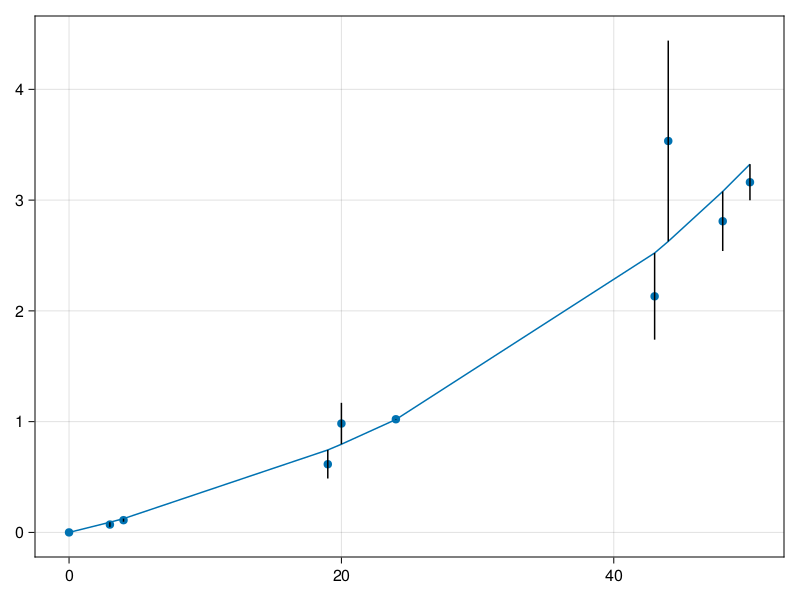

In [ ]:
fig10 = scatter(size.time, size.abs_size_normalized)
lines!(fig10.axis, size.time, y2.-1)
errorbars!(fig10.axis, size.time, size.abs_size_normalized,fit2.resid  )
fig10

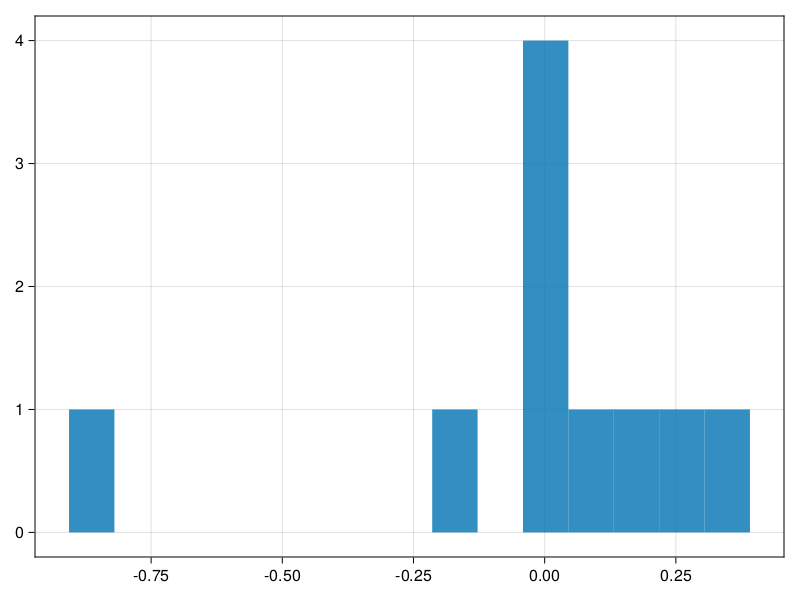

In [ ]:
hist(fit2.resid)

In [ ]:
size_indu = @chain data_full begin 
    groupby([:time,:data_set])
    @combine(:abs_size = mean(sum.(:metric_cov)) ,:abs_size_normalized = mean(sum.(:metric_cov))./mean(:OG_size) ,:OG_size = mean(:OG_size) )
    sort!(:time)
end

Row,time,data_set,abs_size,abs_size_normalized,OG_size
,Int64,String,Float64,Float64,Float64
1,0,14_06_23_stacked_full_res,15195.5,1.0,15195.5
2,0,17_05_23_stacked_full_res,19961.7,1.0,19961.7
3,0,19_12_22_stacked_full_res,16909.8,1.0,16909.8
4,0,26_06_23_stacked_full_res,28744.0,1.0,28744.0
5,3,26_06_23_stacked_full_res,1162.62,0.0404476,28744.0
6,4,14_06_23_stacked_full_res,771.333,0.0507606,15195.5
7,19,26_06_23_stacked_full_res,10100.8,0.351404,28744.0
8,20,14_06_23_stacked_full_res,6894.33,0.453709,15195.5
9,24,14_06_23_stacked_full_res,11754.7,0.773562,15195.5


In [ ]:
cor_size_indu = size_indu.abs_size_normalized.+1;

In [ ]:
ex(x,p) =(1+(p[1])).^x
p1 = [0.001]
fit2 = curve_fit(ex,size_indu.time ,cor_size_indu , p1)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.02722867863265083], [-1.0, -1.0, -1.0, -1.0, 0.043482854418997796, 0.06268377746148968, 0.31459846010434234, 0.2576563875718967, 0.13194776155599475, 0.09118697720397129, 0.30656571407372746, 0.21953651556900788, 0.38847221095236106, -0.6598409043982802, -0.6444636401512871, 0.12618819956699978, 0.49816715136848755, -0.043375246972138015], [0.0; 0.0; … ; 169.6667034578143; 186.49176561927968;;], true, Float64[])

In [ ]:
y2 = ex(size_indu.time,fit2.param)
fit2.param

1-element Vector{Float64}:
 0.02722867863265083

In [ ]:
y2

18-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0839304260861282
 1.1134444193181796
 1.6660022313261624
 1.7113652706842215
 1.9055101100582925
 1.9055101100582925
 1.9055101100582925
 1.9055101100582925
 3.1745840951716766
 3.2610238252914305
 3.6309687795343657
 3.6309687795343657
 3.6309687795343657
 3.8313937472471733

In [ ]:
1/fit2.param[1]

36.7259834195871

In [ ]:
fit2.resid

18-element Vector{Float64}:
 -1.0
 -1.0
 -1.0
 -1.0
  0.043482854418997796
  0.06268377746148968
  0.31459846010434234
  0.2576563875718967
  0.13194776155599475
  0.09118697720397129
  0.30656571407372746
  0.21953651556900788
  0.38847221095236106
 -0.6598409043982802
 -0.6444636401512871
  0.12618819956699978
  0.49816715136848755
 -0.043375246972138015

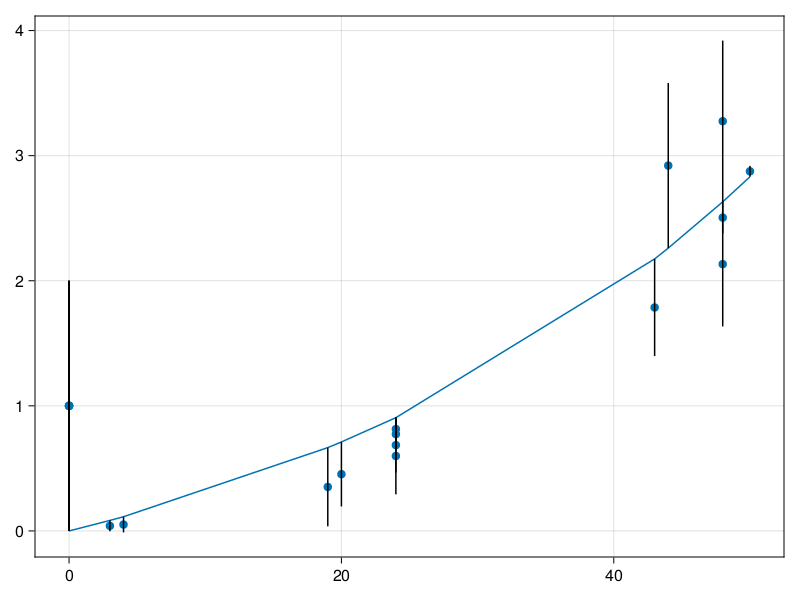

In [ ]:
fig10 =scatter(size_indu.time, size_indu.abs_size_normalized)
lines!(fig10.axis, size_indu.time, y2.-1)
errorbars!(fig10.axis, size_indu.time, size_indu.abs_size_normalized,fit2.resid  )
fig10

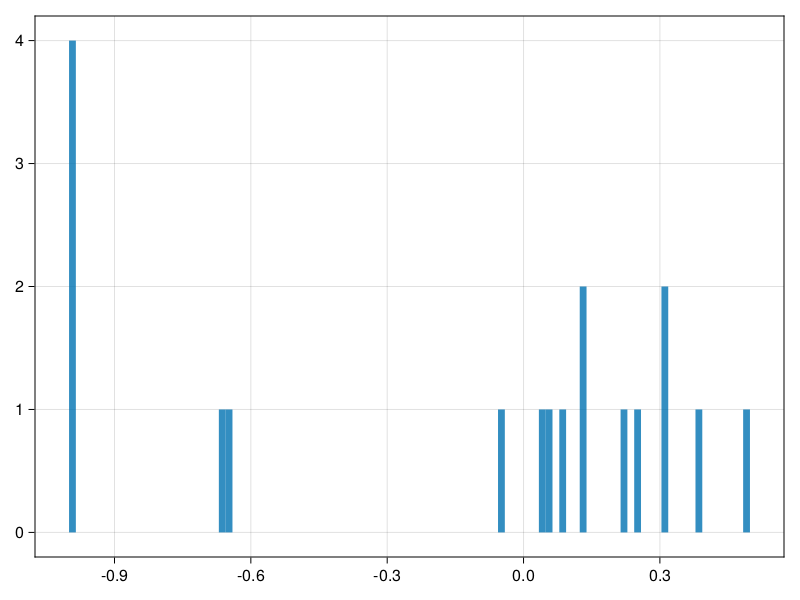

In [ ]:
hist(fit2.resid, bins = 100)

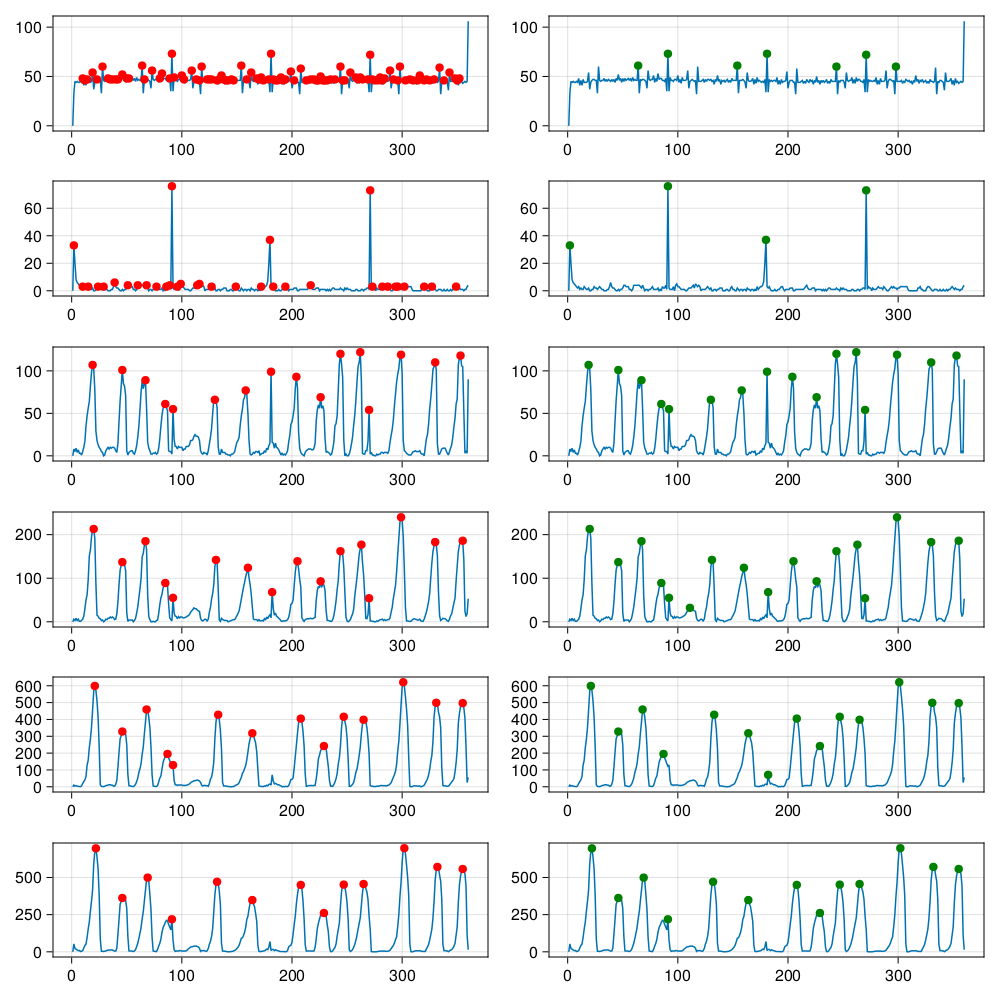

In [ ]:
fig4 = Figure(resolution = (1000,1000))
for i in 1:6
    data = data_full.metric_cov[i+24]
    ax = CairoMakie.Axis(fig4[i,1])
    lines!(ax, data)
    pos_peak, nr_peaks = find_peaks(data, threshold= 1)
    scatter!(ax, pos_peak,data[[pos_peak...]], color = "red" )
    
    ax = CairoMakie.Axis(fig4[i,2])
    lines!(ax, data)
    pkindices, properties = findpeaks1d(data, prominence=0.5*mean(data), distance = 5, height = 30)
    scatter!(ax, pkindices, data[[pkindices...]],color = "green" )
end
fig4
    
    

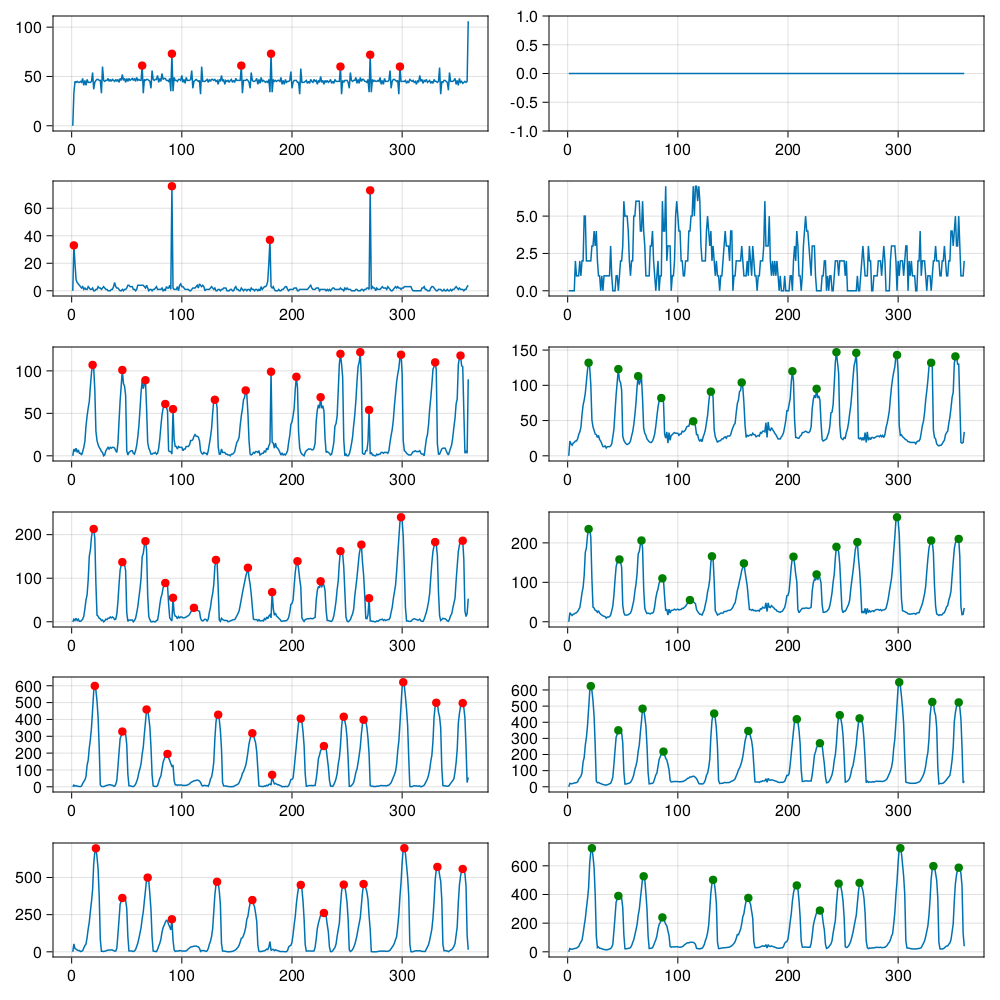

In [ ]:
fig4 = Figure(resolution = (1000,1000))
for i in 1:6
    data = data_full.metric_cov[i+24]
    ax = CairoMakie.Axis(fig4[i,1])
    lines!(ax, data)
    pkindices, properties = findpeaks1d(data, prominence=0.5*mean(data), distance = 5, height = 30)
    scatter!(ax, pkindices, data[[pkindices...]],color = "red" )
    
    ax = CairoMakie.Axis(fig4[i,2])
    data = data_full.metric_OG[i+24]

    lines!(ax, data)
    pkindices, properties = findpeaks1d(data, prominence=0.5*mean(data), distance = 5, height = 30)
    scatter!(ax, pkindices, data[[pkindices...]],color = "green" )
end
fig4
    
    

In [ ]:
first(data_full)

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,14_06_23_stacked_full_res,Kolonie-1 seg.tif,0,"[0, 36, 51, 46, 47, 47, 48, 48, 46, 51 … 44, 51, 46, 47, 48, 47, 47, 46, 49, 109]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3117, 5369, 5589, 5610, 5596, 5626, 5537, 5642, 5434, 5611 … 5505, 5562, 5652, 5513, 5652, 5562, 5505, 5716, 5383, 2871]","[5338, 5545, 5520, 5777, 5550, 5610, 5518, 5535, 5527, 5602 … 5616, 5696, 5670, 5574, 5547, 5678, 5615, 5610, 5518, 5621]",16675


In [ ]:
peaks_full  = @chain data_full begin 
    @transform(:nr_peaks_cov = length.([findpeaks1d(i, prominence=0.4*mean(i), distance = 4, height = 30)[1] for i in :metric_cov])  )
    @transform(:nr_peaks_OG = length.([findpeaks1d(i, prominence=0.4*mean(i), distance = 4, height = 30)[1] for i in :metric_OG])  )
end
first(peaks_full)

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size,nr_peaks_cov,nr_peaks_OG
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Int64,Int64
1,14_06_23_stacked_full_res,Kolonie-1 seg.tif,0,"[0, 36, 51, 46, 47, 47, 48, 48, 46, 51 … 44, 51, 46, 47, 48, 47, 47, 46, 49, 109]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3117, 5369, 5589, 5610, 5596, 5626, 5537, 5642, 5434, 5611 … 5505, 5562, 5652, 5513, 5652, 5562, 5505, 5716, 5383, 2871]","[5338, 5545, 5520, 5777, 5550, 5610, 5518, 5535, 5527, 5602 … 5616, 5696, 5670, 5574, 5547, 5678, 5615, 5610, 5518, 5621]",16675,15,0


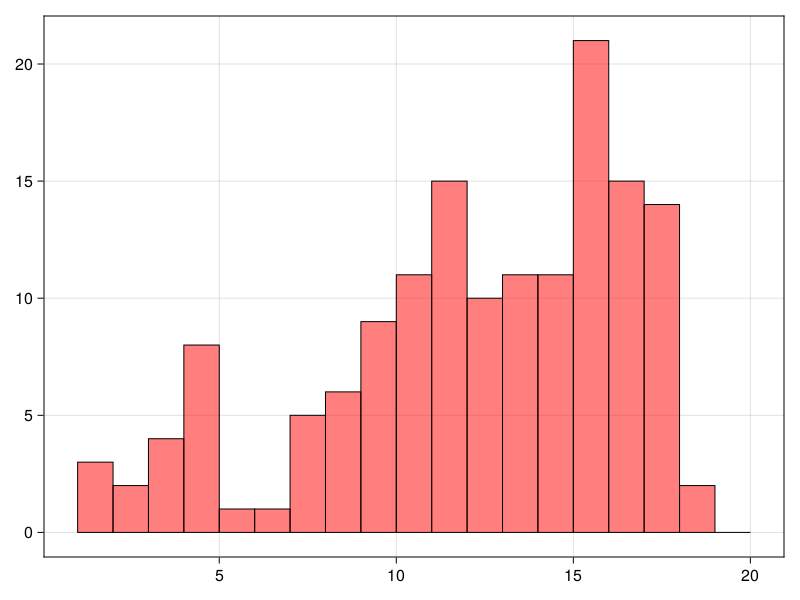

In [ ]:
histi2 = hist(peaks_full.nr_peaks_cov, bins = 1:20,strokewidth = 1, color = (:red,0.5))
#hist!(histi2.axis,peaks_full.nr_peaks_OG, bins = 1:20,strokewidth = 1,color =(:green, 0.5)) 
histi2

In [ ]:
peaks_over_time = @chain peaks_full begin
    groupby(:time)
    @combine(:peaks_mean_cov = mean(:nr_peaks_cov), :peaks_stdd_cov =std(:nr_peaks_cov),
    :peaks_mean_OG = mean(:nr_peaks_OG), :peaks_stdd_OG =std(:nr_peaks_OG))
end

Row,time,peaks_mean_cov,peaks_stdd_cov,peaks_mean_OG,peaks_stdd_OG
,Int64,Float64,Float64,Float64,Float64
1,0,11.0278,4.46885,0.0,0.0
2,3,3.25,1.38873,0.375,1.06066
3,4,2.0,1.26491,0.0,0.0
4,19,11.5,5.12696,12.625,2.97309
5,20,14.5,2.16795,15.1667,0.983192
6,24,13.1389,2.80971,13.2222,2.17927
7,43,15.0,1.60357,14.625,1.50594
8,44,14.1667,1.32916,13.1667,1.94079
9,48,13.5357,1.97169,13.0714,1.69812


In [ ]:
peaks_over_time_all = @chain peaks_full begin
    groupby([:time,:data_set])
    @combine(:peaks_mean_cov = mean(:nr_peaks_cov), :peaks_stdd_cov =std(:nr_peaks_cov) ,
    :peaks_mean_OG = mean(:nr_peaks_OG), :peaks_stdd_OG =std(:nr_peaks_OG))
end


Row,time,data_set,peaks_mean_cov,peaks_stdd_cov,peaks_mean_OG,peaks_stdd_OG
,Int64,String,Float64,Float64,Float64,Float64
1,0,14_06_23_stacked_full_res,15.5,1.3784,0.0,0.0
2,4,14_06_23_stacked_full_res,2.0,1.26491,0.0,0.0
3,20,14_06_23_stacked_full_res,14.5,2.16795,15.1667,0.983192
4,24,14_06_23_stacked_full_res,15.0,1.41421,14.8333,0.983192
5,44,14_06_23_stacked_full_res,14.1667,1.32916,13.1667,1.94079
6,48,14_06_23_stacked_full_res,13.8333,1.7224,12.8333,2.31661
7,0,17_05_23_stacked_full_res,9.71429,3.40652,0.0,0.0
8,24,17_05_23_stacked_full_res,12.2857,2.92018,13.8571,1.29241
9,48,17_05_23_stacked_full_res,12.4286,1.45255,12.2857,0.726273


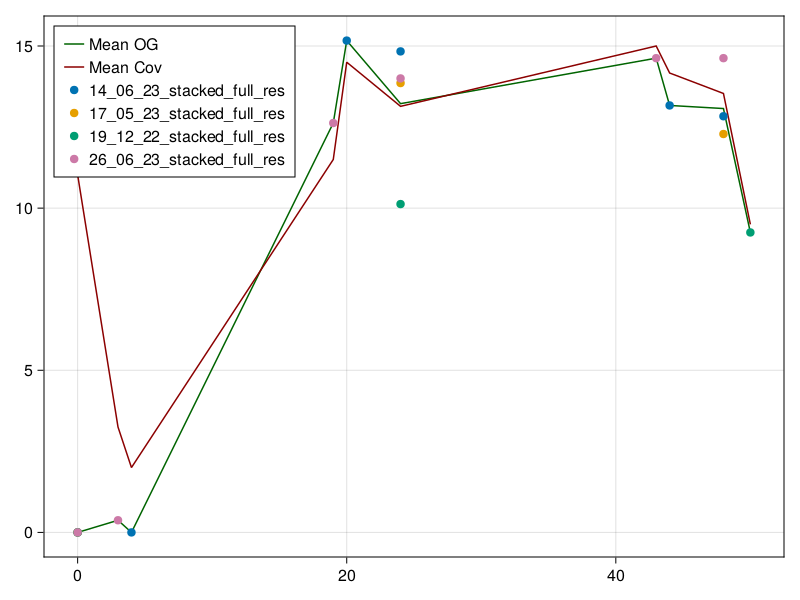

In [ ]:
fig7 = lines(peaks_over_time.time,peaks_over_time.peaks_mean_OG, color = "darkgreen", whiskerwidth = 10, label = "Mean OG")
lines!(fig7.axis,peaks_over_time.time,peaks_over_time.peaks_mean_cov, color = "darkred", whiskerwidth = 10, label = "Mean Cov")
for (k, i) in pairs(groupby(peaks_over_time_all,:data_set))
    #scatter!(fig7.axis, i.time, i.peaks_mean_cov, label = String(k.data_set))
    scatter!(fig7.axis, i.time, i.peaks_mean_OG, label = String(k.data_set))
end
axislegend(fig7.axis, position = :lt)
fig7


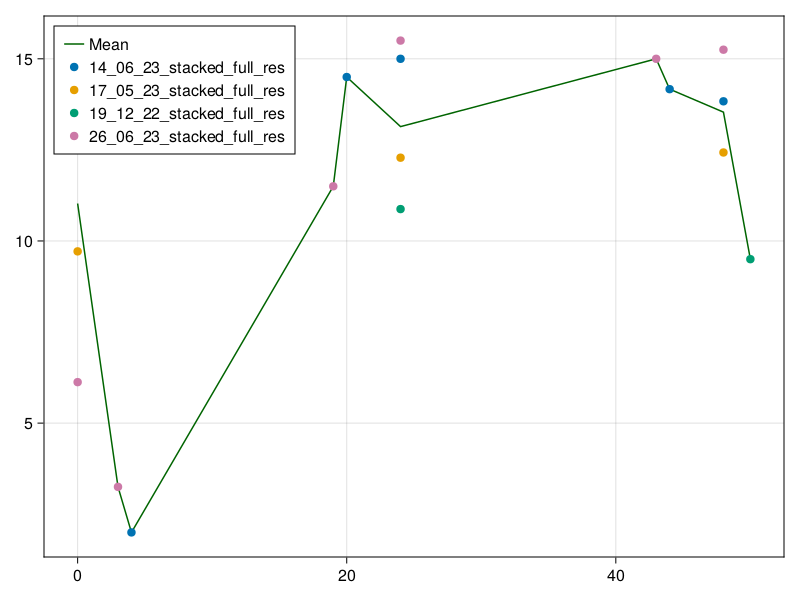

In [ ]:
fig8 = lines(peaks_over_time.time,peaks_over_time.peaks_mean_cov, color = "darkgreen", whiskerwidth = 10, label = "Mean")

for (k, i) in pairs(groupby(peaks_over_time_all,:data_set))
    scatter!(fig8.axis, i.time, i.peaks_mean_cov, label = String(k.data_set))
    #scatter!(fig7.axis, i.time, i.peaks_mean_OG, label = String(k.data_set))
end
axislegend(fig8.axis, position = :lt)
fig8

In [ ]:
outliner_peaks = @subset(data_full, :time .== 20)
#first(outliner_peaks)

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,14_06_23_stacked_full_res,Kolonie-1 seg.tif,20,"[0, 16, 20, 24, 33, 28, 16, 7, 5, 3 … 1, 2, 2, 1, 1, 0, 0, 1, 2, 104]","[0, 46, 38, 50, 57, 53, 40, 30, 30, 27 … 26, 26, 27, 25, 25, 25, 24, 27, 22, 61]","[3022, 6227, 6049, 6095, 6048, 5950, 5933, 5846, 5788, 5822 … 5474, 5452, 5407, 5292, 5479, 5473, 5564, 5450, 5505, 2687]","[12716, 10017, 9683, 9298, 8816, 8163, 7364, 6751, 6487, 5798 … 6011, 6138, 5883, 5803, 6170, 6057, 6088, 6008, 5970, 8752]",16675
2,14_06_23_stacked_full_res,Kolonie-3 seg.tif,20,"[0, 6, 34, 16, 7, 7, 6, 10, 15, 18 … 19, 17, 15, 8, 2, 4, 9, 5, 4, 12]","[0, 17, 24, 21, 26, 27, 30, 35, 39, 45 … 37, 39, 36, 29, 21, 17, 13, 16, 21, 26]","[3162, 6349, 6303, 6174, 6153, 5954, 6118, 5960, 5828, 5740 … 5314, 5567, 5456, 5506, 5599, 5493, 5736, 5561, 5567, 2818]","[11539, 9303, 8825, 8412, 7533, 7376, 7292, 6564, 5751, 5538 … 5184, 4889, 5265, 5174, 4951, 4693, 4898, 5067, 5151, 7373]",13665
3,14_06_23_stacked_full_res,Kolonie-5 seg.tif,20,"[11, 66, 72, 54, 36, 20, 12, 4, 4, 5 … 3, 2, 6, 5, 13, 18, 27, 38, 53, 119]","[11, 95, 74, 59, 47, 39, 31, 24, 21, 23 … 25, 26, 29, 29, 35, 42, 49, 62, 75, 165]","[3681, 7127, 7037, 7084, 6887, 6620, 6587, 6452, 6182, 5961 … 5608, 5709, 5423, 5618, 5494, 5471, 5482, 5410, 5500, 2667]","[12214, 11238, 10910, 10509, 9783, 9004, 8399, 7661, 6895, 6223 … 5413, 5434, 5533, 5345, 5583, 5606, 5885, 5950, 5895, 6571]",16407
4,14_06_23_stacked_full_res,Kolonie-6 seg.tif,20,"[0, 8, 4, 4, 5, 2, 1, 3, 9, 10 … 1, 7, 21, 26, 32, 38, 39, 46, 59, 20]","[0, 10, 18, 12, 13, 16, 17, 21, 26, 29 … 17, 24, 38, 43, 47, 51, 50, 49, 49, 33]","[4041, 7882, 7821, 7697, 7344, 7038, 6736, 6574, 6244, 6044 … 5294, 5432, 5181, 5166, 5124, 5201, 5179, 4871, 4948, 2565]","[12709, 11646, 11338, 10697, 9803, 9319, 8647, 8043, 7214, 6586 … 5540, 5443, 5248, 5194, 5100, 5049, 4865, 4904, 4868, 5601]",14333
5,14_06_23_stacked_full_res,Kolonie-7 seg.tif,20,"[0, 8, 5, 9, 4, 7, 3, 3, 1, 5 … 107, 116, 118, 106, 105, 53, 3, 6, 3, 90]","[0, 21, 17, 15, 18, 19, 21, 21, 24, 30 … 131, 141, 141, 130, 130, 75, 19, 18, 19, 34]","[4206, 8469, 7963, 7872, 7632, 7130, 6986, 6704, 6366, 6203 … 5523, 5669, 5656, 5754, 5794, 5939, 5707, 5844, 5999, 2876]","[14114, 13009, 12440, 11590, 10759, 9790, 8758, 7812, 7041, 6233 … 5025, 5251, 5451, 5520, 5819, 6069, 6376, 6529, 6450, 7244]",16455
6,14_06_23_stacked_full_res,Kolonie-8 seg.tif,20,"[0, 17, 9, 34, 24, 19, 9, 7, 12, 12 … 1, 4, 5, 4, 7, 0, 4, 11, 7, 25]","[0, 43, 36, 40, 34, 33, 29, 22, 18, 16 … 21, 19, 18, 19, 17, 22, 28, 35, 34, 69]","[4060, 7771, 7592, 7571, 7230, 7174, 6803, 6446, 6425, 6155 … 5464, 5537, 5465, 5478, 5556, 5484, 5494, 5453, 5600, 2817]","[13560, 12347, 11972, 10958, 10210, 9656, 8910, 8192, 7395, 6979 … 4699, 4814, 4983, 5116, 5235, 5176, 5322, 5711, 5749, 6822]",13638


In [ ]:
outliner_peaks.metric_OG[2]

360-element Vector{Int64}:
  0
 17
 24
 21
 26
 27
 30
 35
 39
 45
 43
 56
 61
  ⋮
 49
 41
 37
 39
 36
 29
 21
 17
 13
 16
 21
 26

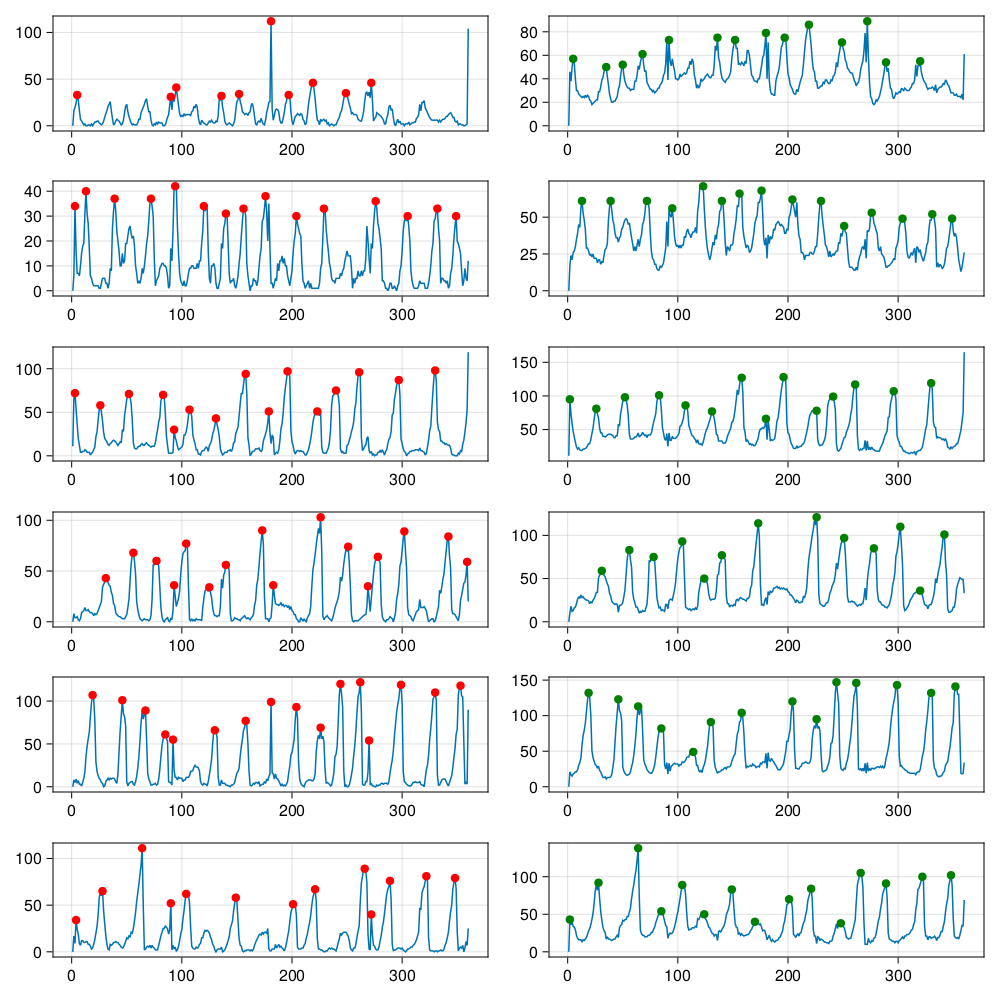

In [ ]:
fig9 = Figure(resolution = (1000,1000))
for i in 1:6
    data2 = outliner_peaks.metric_cov[i]
    ax = CairoMakie.Axis(fig9[i,1])
    lines!(ax, data2)
    pkindices, properties = findpeaks1d(data2, prominence=0.5*mean(data2), distance = 5, height = 30)
    scatter!(ax, pkindices, data2[[pkindices...]],color = "red" )
    
    ax = CairoMakie.Axis(fig9[i,2])
    data2 = outliner_peaks.metric_OG[i]

    lines!(ax, data2)
    pkindices, properties = findpeaks1d(data2, prominence=0.5*mean(data2), distance = 5, height = 30)
    scatter!(ax, pkindices, data2[[pkindices...]],color = "green" )
end
fig9

In [86]:
fIndex_fil = @chain df_f begin 
    @subset(:data_set .== "Daten vom 10-04-23 stacked")
    groupby(:time)
    @combine(:data_stet = :data_set[1],:fil_OG = mean(sum.(:abs_OG)), :fil_cov = mean(sum.(:abs_cov)))
end

LoadError: UndefVarError: `df_f` not defined

In [87]:
pair_10 = @chain data begin
    @subset(:data_set .== "Daten vom 10-04-23 stacked")
    groupby(:time)
    @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
        :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
    

end

Row,time,pair_og,pair_og_stdd
,Int64,Float64,Float64


In [88]:
fig = CairoMakie.scatter(pair_10.pair_og)
errorbars!(1:length(pair_10.time),pair_10.pair_og, pair_10.pair_og_stdd,whiskerwidth = 10)
fig

LoadError: `Makie.convert_arguments` for the plot type LineSegments{Tuple{Vector{Any}}} and its conversion trait PointBased() was unsuccessful.

The signature that could not be converted was:
::Vector{Any}

Makie needs to convert all plot input arguments to types that can be consumed by the backends (typically Arrays with Float32 elements).
You can define a method for `Makie.convert_arguments` (a type recipe) for these types or their supertypes to make this set of arguments convertible (See http://docs.makie.org/stable/documentation/recipes/index.html).

Alternatively, you can define `Makie.convert_single_argument` for single arguments which have types that are unknown to Makie but which can be converted to known types and fed back to the conversion pipeline.


In [ ]:
data_14 = @subset(data,:data_set .== "14_06_23_stacked_full_res")
first(data_14,3)

LoadError: MethodError: no method matching subset(::Vector{Int64}, ::Pair{Vector{Symbol}, var"#129#130"}; skipmissing::Bool)

[0mClosest candidates are:
[0m  subset([91m::AbstractDataFrame[39m, ::Any...; skipmissing, view, threads)
[0m[90m   @[39m [35mDataFrames[39m [90mC:\Users\Andreas\.julia\packages\DataFrames\58MUJ\src\abstractdataframe\[39m[90m[4msubset.jl:278[24m[39m
[0m  subset([91m::GroupedDataFrame[39m, ::Any...; skipmissing, view, ungroup, threads)
[0m[90m   @[39m [35mDataFrames[39m [90mC:\Users\Andreas\.julia\packages\DataFrames\58MUJ\src\abstractdataframe\[39m[90m[4msubset.jl:290[24m[39m
